<a href="https://colab.research.google.com/github/wxyyoyo/wxyyoyo.github.io/blob/main/simple_draw_with_pygame_pymunk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@markdown ### In this file I will explore the python libraries pygame, pymunk, gym and geomdl to create the objects and environments with different needs.
#@markdown ### It is the preparation for the coming learning policies.
#@markdown ### In general here are a few take aways.
#@markdown - pygame is the drawing engine.
#@markdown - pymunk is the physics engine.
#@markdown - gym creates the environment for the objects.
#@markdown - geomdl is the customized curve shapes engine.
!python --version
!pip3 install scikit-image==0.19.3 scikit-video==1.1.11 zarr==2.12.0 numcodecs==0.10.2 \
pygame==2.1.2 pymunk==6.2.1 gym==0.26.2 shapely==1.8.4 \
&> /dev/null # mute output

Python 3.10.12


In [ ]:
#@markdown ### **Imports**
from typing import Tuple, Sequence, Dict, Union, Optional
import numpy as np
import math


# env import
import gym
from gym import spaces
import pygame
import pymunk
import pymunk.pygame_util
from pymunk.space_debug_draw_options import SpaceDebugColor
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import skimage.transform as st
from skvideo.io import vwrite
from IPython.display import Video
import gdown
import os

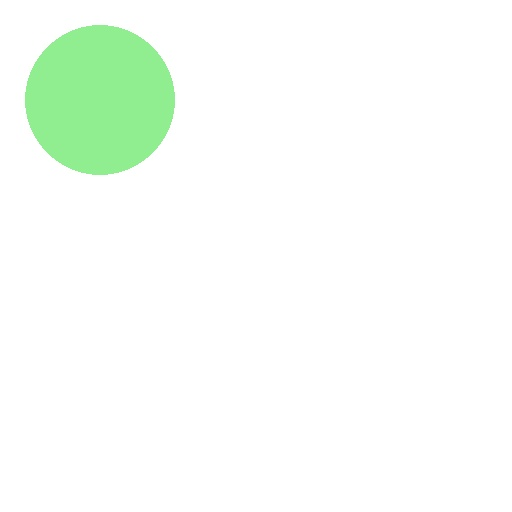

In [ ]:
#@markdown ### I will first start with darwing a simplest static shape (e.g. a circle) using the propertities in pygame without including any physics.
#@markdown - step1: initiate a pygame surface
#@markdown - step2: draw a simple circle by calling pygame.draw.circle()
#@markdown - step3: visualize. Note that Colab doesn't surpport visualizing pygame images, so the results need to be written and read by a seperate visualizer.
# test pygame draw options. pygame can draw without physics driven motions. In this module no pymunk is required.
# 1, initiate a pygame surface
WINDOW = pygame.Surface((512, 512))
WINDOW.fill((255, 255, 255))

# 2, draw a simple circle
# simply call pygame.draw.circle()
pygame.draw.circle(WINDOW, pygame.Color('LightGreen'), (100, 100), 75)
# 3, visualize the drawing
# pygame images cannot be visualized on google colab, so I copied it by cv2 into other image files.
img = np.transpose(np.array(pygame.surfarray.pixels3d(WINDOW)), axes=(1, 0, 2))
img = cv2.resize(img, (512, 512))
cv2.imwrite("img.jpg", img)
from IPython.display import Image
Image(filename = "img.jpg")


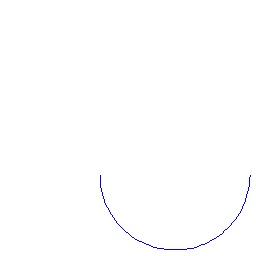

In [ ]:
#@markdown Call pygame.draw.arc to draw a arc with customized angles.
surface_test = pygame.Surface((256, 256))
surface_test.fill((255,255,255))
rect = pygame.Rect((100,100),(150,150)) # (left, top), (width,height)
#pygame.draw.rect(surface_test, (100, 100, 100), rect)
pygame.draw.arc(surface_test,(255,0,0), rect, np.pi, 2* np.pi)


img = np.transpose(np.array(pygame.surfarray.pixels3d(surface_test)), axes=(1, 0, 2))
img = cv2.resize(img, (256, 256))
cv2.imwrite("img.jpg", img)
from IPython.display import Image
Image(filename = "img.jpg")

In [ ]:
#@markdown Now let's customize a environment together by gym and pygame.
#@markdown The moving target (the square), and the agent(circle) is not driven by any physics.

import gym
from gym import spaces
# test pygame used in a gym environment.
# create a gym.env
class TestEnv(gym.Env):
  # declaration and initiation
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}
    def __init__(self, render_mode=None, size=5):
      self.size = size  # The size of the square grid
      self.window_size = 512  # The size of the PyGame window
      # Observations are dictionaries with the agent's and the target's location.
      # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
      self.observation_space= spaces.Dict(
          {"agent": spaces.Box(0, size-1, shape=(2,), dtype = int), # agent has 2 dimensions to move horizental or verticle
           "target": spaces.Box(0, size-1, shape = (2,), dtype = int), # target has 2 dimensions to move
      })

      self.action_space = spaces.Discrete(4) # 4 actions: up, down, left, right
      """
        The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
      """
      self._action_to_direction = {0: np.array([1,0]),
      1: np.array([0,1]),
      2: np.array([-1, 0]),
      3: np.array([0,-1]),
      }

      assert render_mode is None or render_mode in self.metadata["render_modes"]
      self.render_mode = render_mode
      self.window = None
      self.clock = None

    #Constructing Observations From Environment States
    def _get_obs(self):
        return {"agent_location": self._agent_location, "target_location": self._target_location}

    def _get_info(self):
        return np.linalg.norm(self._agent_location - self._target_location, ord=1)

      #reset
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # reset agent and target position
        self._agent_location = np.random.randint(0, self.size, size=2)
        self._target_location = self._agent_location


        while np.array_equal(self._target_location, self._agent_location):
          self._target_location = np.random.randint(0, self.size, size = 2)


        observation = self._get_obs()
        info = self._get_info()
        if self.render_mode == "human":
          self._render_frame()
        return observation, info

    # step
    def step(self, action):

          # map the direction of action
          direction = self._action_to_direction[action]
          self._agent_location = np.clip(self._agent_location + direction, 0, self.size-1)
          # An episode is done iff the agent has reached the target
          terminated = np.array_equal(self._agent_location, self._target_location)
          reward = 1 if terminated else 0
          observation = self._get_obs()
          info = self._get_info()
          if self.render_mode == "human":
            self._render_frame()
          return observation, reward, terminated, False, info

    # rendering
    def render(self):
          if self.render_mode == 'rgb_array':
            return self._render_frame()

    def _render_frame(self):
          if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
          if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

          canvas = pygame.Surface((self.window_size, self.window_size))
          canvas.fill((255, 255, 255))
          pix_square_size = self.window_size/self.size # the size of a single grid square in pixels

          # draw target
          pygame.draw.rect(canvas,(100,0,0), pygame.Rect((pix_square_size*self._target_location[0], pix_square_size*self._target_location[1]), (pix_square_size, pix_square_size)))


          # draw agent
          pygame.draw.circle(canvas,(0,0,255), (self._agent_location + 0.5) * pix_square_size , pix_square_size/3)

          # draw grid lines
          for x in range(self.size +1):
            pygame.draw.line(canvas,0, (0, pix_square_size * x), (self.window_size, pix_square_size * x), width = 3)
            pygame.draw.line(canvas,0, (pix_square_size * x, 0), (pix_square_size * x, self.window_size), width = 3)

          if self.render_mode == "human":
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
          else: # rgb_gray
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
    def close(self):
          if self.window is not None:
            pygame.display.quit()
            pygame.quit()

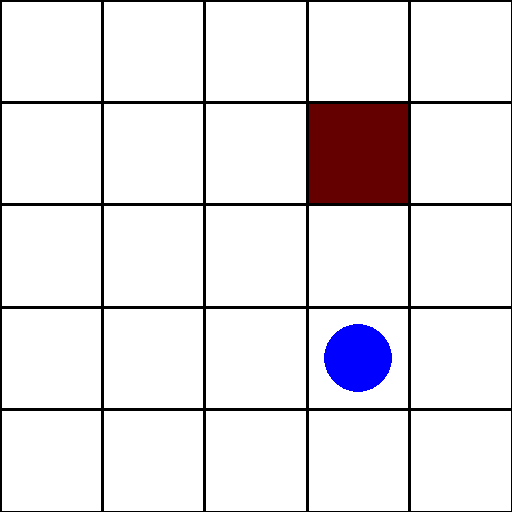

In [ ]:
#test pygame env
myenv = TestEnv(render_mode="rgb_array")
obs, info = myenv.reset(seed = 800)


images = [myenv.render()]
for _ in range(200):
    action = myenv.action_space.sample() # the actions are sampled by random
    observation, reward, terminated, truncated, info = myenv.step(action)
    images.append(myenv.render())

    if terminated or truncated:
        observation, info = myenv.reset()
        images.append(myenv.render())
myenv.close()


%pip install numpngw
from numpngw import write_apng
write_apng("anim.png", images, delay=250)  # real-time rendering = 250 ms between frames
from IPython.display import Image

Image(filename="anim.png")

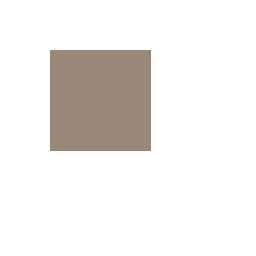

In [ ]:
#@markdown So the next task is to draw objects with physics. Then we need to use the pymunk library.
#@markdown pymunk.pygame_util.DrawOptions(surface) will be called to quickly draw pymunk objects on pygame surface.
#@markdown This example will show a simple static box with mass, height, width and inertia.

mass = 1
height=100
width=100
position = Vec2d(100,100)
space = pymunk.Space()
inertia = pymunk.moment_for_box(mass, (height, width))
body = pymunk.Body(mass, inertia)
body.position = position
shape = pymunk.Poly.create_box(body, (height, width))
shape.color = pygame.Color('LightSlateGray')
space.add(body, shape)
canvas = pygame.Surface((256, 256))
canvas.fill((255, 255, 255))
options = pymunk.pygame_util.DrawOptions(canvas)
space.debug_draw(options)

#save and print out the image
img = np.transpose(np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2))
img = cv2.resize(img, (256, 256))
cv2.imwrite("img.jpg", img)
from IPython.display import Image
Image(filename = "img.jpg")

In [ ]:
#@markdown Now let's test the physical motions in pymunk.
#@markdown A moving ball with constant velocity to the direction of right corner.
mass = 1
radius = 10
position = Vec2d(100,100)
space = pymunk.Space()
inertia = pymunk.moment_for_circle(mass, 0, radius, offset=(0,0))
body = pymunk.Body(mass, inertia, body_type = pymunk.Body.KINEMATIC)
body.position = position
shape = pymunk.Circle(body, radius)
shape.color = pygame.Color('LightSlateGray')
space.add(body, shape)
canvas = pygame.Surface((256, 256))
canvas.fill((255, 255, 100))
options = pymunk.pygame_util.DrawOptions(canvas)
space.debug_draw(options)
img = np.transpose(np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2))
img = cv2.resize(img, (256, 256))
images = [img]
body.velocity = (100,100) # constant velocity
physics_steps_per_frame = 100
dt = 1/60

for x in range(physics_steps_per_frame):
  space.step(dt)
  canvas.fill((255, 255, 100))
  space.debug_draw(options)
  img = np.transpose(np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2))
  img = cv2.resize(img, (256, 256))
  images.append(img)

#save and print out the image
'''
#%pip install numpngw
from numpngw import write_apng
write_apng("anim.png", images, delay=250)  # real-time rendering = 250 ms between frames
from IPython.display import Image
Image(filename="anim.png")
'''

from IPython.display import Video
vwrite('vis.mp4', images)
Video('vis.mp4', embed=True, width=256, height=256)

In [ ]:
#@markdown Now let's try a scenario of free fall.
#@markdown There will be a static beam laying flat on the bottom and 2 balls with different
#@markdown mass but the same elasticity and friction bouncing on the static beam. We will visualize
#@markdown the balls fall on the same velocity and whether both of them will bounce up
#@markdown from the beam.
# initiate a pymunk space with gravity
space = pymunk.Space()
space.gravity=(0.0, 9.8) # play with the gravity positive or negative

# create a static line
# the ball will bounce on this line
static_body = space.static_body #convinient call from pymunk bilt-in properties
static_line = pymunk.Segment(static_body, (230.0, 156), (20.0, 156), 0.0)
static_line.elasticity = 0.95
static_line.friction = 0.9
space.add(static_line)

# create a ball
mass = 1
radius = 10
position = Vec2d(50,50)
inertia = pymunk.moment_for_circle(mass, 0, radius, offset=(0,0))
body = pymunk.Body(mass, inertia, body_type = pymunk.Body.DYNAMIC)
body.position = position
shape = pymunk.Circle(body, radius)
shape.elasticity = 0.9
shape.friction = 0.1
shape.color = (0, 255, 255, 0) #color code:  https://htmlcolorcodes.com/color-names/
space.add(body, shape)

# create a second ball
mass2 = 2
radius2 = 10
position2 = Vec2d(100, 50)
inertia2 = pymunk.moment_for_circle(mass2, 0, radius2, offset = (0,0))
body2 = pymunk.Body(mass2, inertia2, body_type = pymunk.Body.DYNAMIC)
body2.position = position2
shape2 = pymunk.Circle(body2, radius2)
shape2.color = (255, 0, 0, 255) # will draw my_shape in red

shape2.elastisity = 0.9
shape2.friction = 0.1
space.add(body2, shape2)

# draw
canvas_ball = pygame.Surface((256, 256))
canvas_ball.fill((255, 255, 100))
options = pymunk.pygame_util.DrawOptions(canvas_ball)

space.debug_draw(options)
img = np.transpose(np.array(pygame.surfarray.pixels3d(canvas_ball)), axes=(1, 0, 2))
img = cv2.resize(img, (256, 256))
images = [img]
physics_steps_per_frame = 400
dt = 1/60

for x in range(physics_steps_per_frame):
  space.step(dt)
  canvas_ball.fill((255, 255, 100))
  space.debug_draw(options)
  img = np.transpose(np.array(pygame.surfarray.pixels3d(canvas_ball)), axes=(1, 0, 2))
  img = cv2.resize(img, (256, 256))
  images.append(img)
  # check the velocity of 2 balls at each step
  #print('the blue ball vvelocity is:',body.velocity)
  #print('the red ball velocity is:',body2.velocity)

#save and print out the image
# about 2 times slow motion
from IPython.display import Video
vwrite('vis.mp4', images)
Video('vis.mp4', embed=True, width=256, height=256)






In [ ]:
#@markdown Now let's play marble run.
#@markdown In this example, we will use geomdl library to generate the curvy part of the
#@markdown static scenery. Currently there are only a few shape options in pymunk, e.g. circle, straight segments and box.
#@markdown However, tt is convenient to construct a customized curve by exploring the
#@markdown [B-Spline Geometry](https://nurbs-python.readthedocs.io/en/latest/module_bspline.html?highlight=knotvector#geomdl.BSpline.Curve.knotvector).
#@markdown In this example a sequence of elastic balls with random impulse at the starting point will be generated.
#@markdown However, since pymunk does not support 3D objects at this moment, it will not be able
#@markdown to test the task loop the loop! We will save it for future!

!pip install geomdl
from geomdl import BSpline
from geomdl import utilities
from geomdl.visualization import VisMPL

class marble_run(object):
  # this class will simulate a marble run play
  def __init__(self, screen_size:Tuple[float, float]) -> None:
    # screen size
    self._length = round(screen_size[0])
    self._height = round(screen_size[1])

    # space
    self._space = pymunk.Space()
    self._space.gravity = (0.0, 900)

    # physics
    # time step
    self._dt = 1.0 / 60.0
    # Number of physics steps per screen frame
    self._physics_steps_per_frame = 300

    # pygame
    self._canvas = pygame.Surface((self._length, self._height))
    self._canvas.fill((255, 255, 100))
    self._options = pymunk.pygame_util.DrawOptions(self._canvas)

     # Static barrier walls (lines) that the balls bounce off of
    self._add_static_scenery()

    # add bounce ball
    self._add_bounce_ball()

  def _add_static_scenery(self) -> None:
    static_body = self._space.static_body #convinient add body from pymunk bilt-in properties
    # add the first line segment
    static_line = pymunk.Segment(static_body, (0.0, 20), (self._length/4, self._height/2), 1.0)
    static_line.elasticity = 0.1
    static_line.friction = 0.1
    self._space.add(static_line)

    # Create a B-Spline curve
    curve = BSpline.Curve()
    # Set up the curve
    curve.degree = 2
    #curve.ctrlpts = [[self._length/4, self._height/2], [self._length/4 + 100, self._height-50], [self._length/2, self._height/2]]
    curve.ctrlpts = [[self._length/4, self._height/2],[self._length/2,self._height], [self._length, self._height/2]]
    # Auto-generate knot vector
    curve.knotvector = utilities.generate_knot_vector(curve.degree, len(curve.ctrlpts))
    pts = curve.evalpts
    # Set evaluation delta
    curve.delta = 0.01
    # add static lines segment
    for i,p in enumerate(pts[:-1]):
      segment = pymunk.Segment(self._space.static_body,p, pts[i+1], 1)
      segment.elasticity = 0.1
      segment.friction = 0.1
      self._space.add(segment)


  def _add_bounce_ball(self) -> None:
    mass = 1
    radius = 10
    position = Vec2d(5.0,10)
    inertia = pymunk.moment_for_circle(mass, 0, radius, offset=(0,0))
    body = pymunk.Body(mass, inertia, body_type = pymunk.Body.DYNAMIC)
    body.position = position
    self._get_random_impluse(body)

    shape = pymunk.Circle(body, radius)
    shape.elasticity = 0.9
    shape.friction = 0.1
    shape.color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255), 0)
    self._space.add(body, shape)

  def _get_random_impluse(self, ball_body) -> None:
    # generate random pulse in range of [0, 500] applied on the bounce balls
    impulse = ball_body.apply_impulse_at_local_point((np.random.randint(low = 0,high = 500,size = 1), 0))


  def Marble_Run(self):
    # draw
    self._space.debug_draw(self._options)
    img = np.transpose(np.array(pygame.surfarray.pixels3d(self._canvas)), axes=(1, 0, 2))
    img = cv2.resize(img, (self._length, self._height))
    images = [img]
    physics_steps_per_frame = 500
    dt = 1/60

    for x in range(physics_steps_per_frame):
      if (x+1)%50 ==0:
        self._add_bounce_ball()

      self._space.step(dt)
      self._canvas.fill((255, 255, 100))
      self._space.debug_draw(self._options)
      img = np.transpose(np.array(pygame.surfarray.pixels3d(self._canvas)), axes=(1, 0, 2))
      img = cv2.resize(img, (self._length, self._height))
      images.append(img)
    return images



In [ ]:
length = 512
height = 512
game = marble_run([length,height])
images = game.Marble_Run()

from IPython.display import Video
vwrite('vis.mp4', images)
Video('vis.mp4', embed=True, width=length, height=height)

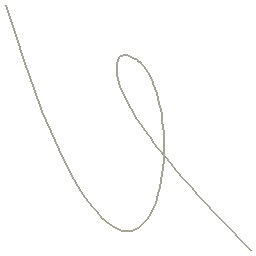

In [ ]:
#@markdown Let's generate a 2D loop just for fun!
#!pip install geomdl
from geomdl import BSpline
from geomdl import utilities
from geomdl.visualization import VisMPL
from geomdl import operations

# Create a B-Spline curve
curve = BSpline.Curve()

# Set up the curve
curve.degree = 4
curve.ctrlpts = [[5.0, 5.0], [250.0/2, 400], [250, 5], [250/2-75, 0], [250/2, 250/2], [250, 250]]
#operations.refine_knotvector(curve, [1])

# Auto-generate knot vector
curve.knotvector = utilities.generate_knot_vector(curve.degree, len(curve.ctrlpts))
pts = curve.evalpts
# Set evaluation delta
curve.delta = 0.1
# try to visualize using pygame
space = pymunk.Space()
space.gravity = 0,900
canvas = pygame.Surface((256,256))
canvas.fill((255, 255, 255))
#static_body = space.static_body #convinient add body from pymunk bilt-in properties
# add the first line segment
for i,p in enumerate(pts[:-1]):
  segment = pymunk.Segment(space.static_body,p, pts[i+1], 1)
  segment.elasticity = 1
  space.add(segment)

options = pymunk.pygame_util.DrawOptions(canvas)
space.debug_draw(options)
img = np.transpose(np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2))
img = cv2.resize(img, (256, 256))
cv2.imwrite("img.jpg", img)
from IPython.display import Image
Image(filename = "img.jpg")
# Plot the control point polygon and the evaluated curve
#curve.vis = VisMPL.VisCurve2D()
#curve.render()